In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
import sys

/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
sys.path.insert(0, "../src")

In [3]:
print(sys.path)

['../src', '/home/sasha/BMM/bayes_deep_compression/examples', '/home/sasha/anaconda3/lib/python311.zip', '/home/sasha/anaconda3/lib/python3.11', '/home/sasha/anaconda3/lib/python3.11/lib-dynload', '', '/home/sasha/anaconda3/lib/python3.11/site-packages']


In [4]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [5]:
from bayescomp.bayes.variational.distribution import LogUniformVarDist
from bayescomp.bayes.variational.net_distribution import VarBayesModuleNetDistribution
from bayescomp.bayes.base.net_distribution import BaseNetDistributionPruner

In [6]:
p = nn.Parameter(torch.tensor([0.0, 1.0]))
LogUniformVarDist.from_parameter(p)

LogUniformVarDist(param_mus: torch.Size([2]), param_std_log: torch.Size([2]), scale_mus: torch.Size([2]), scale_alphas_log: torch.Size([2]))

In [7]:
from bayescomp.bayes.variational.net import LogUniformVarBayesModule, VarBayesModuleNet
from bayescomp.bayes.variational.optimization import LogUniformVarKLLoss


In [8]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6592148.45it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 192913.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1796107.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4114585.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
module = Classifier()

In [10]:
#bayes_model = BayesModule(module)
var_module = LogUniformVarBayesModule(module)
bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [11]:
print(bayes_model)

VarBayesModuleNet(
  (module_list): ModuleList(
    (0): LogUniformVarBayesModule(
      (posterior_params): ParameterList(
          (0): Object of type: ParameterDict
          (1): Object of type: ParameterDict
          (2): Object of type: ParameterDict
          (3): Object of type: ParameterDict
          (4): Object of type: ParameterDict
          (5): Object of type: ParameterDict
          (6): Object of type: ParameterDict
          (7): Object of type: ParameterDict
        (0): ParameterDict(
            (param_mus): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (param_std_log): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (scale_alphas_log): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (scale_mus): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
        )
        (1): ParameterDict(
            (param_mus): Parameter containing: [torch.FloatTensor of size 32]
            (param_std_lo

In [12]:
cnt = 0
for i, p in enumerate(bayes_model.parameters()):
    cnt += 1
print(cnt)

32


In [13]:
a = torch.tensor([[0, 2.], [3, 0]])
b =  torch.tensor([1., 1.])
a_s = a.to_sparse()
print(a_s @ b)

tensor([2., 3.])


In [14]:
optimizer = optim.Adam(bayes_model.parameters(), lr=0.1)

In [15]:
bayes_model.prior

{'conv1.weight': None,
 'conv1.bias': None,
 'conv2.weight': None,
 'conv2.bias': None,
 'fc1.weight': None,
 'fc1.bias': None,
 'fc2.weight': None,
 'fc2.bias': None}

In [16]:
image, label = test_dataset[10]
y = bayes_model(torch.ones_like(image))
kl_loss = LogUniformVarKLLoss()
bayes_model.prior
out = y.sum() + kl_loss(bayes_model.weights, bayes_model.posterior, bayes_model.prior)
optimizer.zero_grad() 
out.backward() 
optimizer.step() 

In [17]:
net_distributon = VarBayesModuleNetDistribution(bayes_model.base_module, bayes_model.posterior)
net_distributon_pruner = BaseNetDistributionPruner(net_distributon)
net_distributon.set_map_params()
net_distributon_pruner.prune(-2.2)
#get basic model for evaluation
eval_model = net_distributon.get_model()

In [18]:
print(eval_model.conv1.weight)

Parameter containing:
tensor([[[[-1.7739e-01,  4.8183e-02, -7.3418e-02],
          [ 1.2302e-01,  1.6080e-01, -2.2654e-03],
          [-2.0022e-02, -2.0802e-01,  8.2771e-02]]],


        [[[-2.2365e-01, -4.5209e-02, -6.6389e-02],
          [ 4.6611e-02,  3.8977e-02, -2.1094e-01],
          [ 4.0353e-02, -1.8961e-01, -6.4226e-02]]],


        [[[-4.1916e-02,  7.5624e-02,  7.2735e-02],
          [ 6.4230e-02,  9.6525e-02, -1.5932e-01],
          [ 8.0029e-02, -1.9937e-01, -1.0564e-01]]],


        [[[-9.5881e-03, -6.3533e-03, -1.6173e-01],
          [ 7.2034e-02,  2.1627e-01, -1.4444e-01],
          [-1.1444e-01, -2.3313e-01, -8.8791e-02]]],


        [[[ 5.6789e-02,  3.4321e-02,  1.6554e-01],
          [-8.0557e-02, -1.0476e-01,  1.4158e-01],
          [ 6.8749e-02,  1.2548e-01,  2.5378e-02]]],


        [[[-3.3215e-02,  6.9166e-02, -1.7316e-01],
          [ 1.7167e-02, -1.6875e-01, -7.5956e-02],
          [ 3.1626e-02, -3.1497e-02,  6.2589e-02]]],


        [[[ 1.6173e-02,  1.3643e-01,

In [19]:
bayes_model.state_dict()

OrderedDict([('module_list.0.posterior_params.0.param_mus',
              tensor([[[[-1.7739e-01,  4.8183e-02, -7.3418e-02],
                        [ 1.2302e-01,  1.6080e-01, -2.2654e-03],
                        [-2.0022e-02, -2.0802e-01,  8.2771e-02]]],
              
              
                      [[[-2.2365e-01, -4.5209e-02, -6.6389e-02],
                        [ 4.6611e-02,  3.8977e-02, -2.1094e-01],
                        [ 4.0353e-02, -1.8961e-01, -6.4226e-02]]],
              
              
                      [[[-4.1916e-02,  7.5624e-02,  7.2735e-02],
                        [ 6.4230e-02,  9.6525e-02, -1.5932e-01],
                        [ 8.0029e-02, -1.9937e-01, -1.0564e-01]]],
              
              
                      [[[-9.5881e-03, -6.3533e-03, -1.6173e-01],
                        [ 7.2034e-02,  2.1627e-01, -1.4444e-01],
                        [-1.1444e-01, -2.3313e-01, -8.8791e-02]]],
              
              
                      [[[ 5.6789

In [20]:
print(bayes_model(torch.zeros_like(image)))
#print(bayes_model(torch.zeros_like(image), sample = False))
print(module(torch.zeros_like(image)))

tensor([[ 0.2574,  0.0943, -0.2167, -0.3983,  0.0213,  0.2146, -0.0947,  0.1659,
          0.1276,  0.3128]], grad_fn=<AddmmBackward0>)
tensor([[ 0.2574,  0.0943, -0.2167, -0.3983,  0.0213,  0.2146, -0.0947,  0.1659,
          0.1276,  0.3128]], grad_fn=<AddmmBackward0>)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
from bayescomp.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Scheduler_Plato, CallbackLossAccuracy
from bayescomp.report.base import ReportChain
from bayescomp.report.variational import VarBaseReport

In [23]:
beta = Beta_Scheduler_Plato()

In [24]:
x = torch.tensor([1., 2.], requires_grad=True)
print(x)
y = x ** 2
print(y)
z = nn.Parameter(y)
loss = z.sum()
print(z)
loss .backward()
print(z)
print(x)

tensor([1., 2.], requires_grad=True)
tensor([1., 4.], grad_fn=<PowBackward0>)
Parameter containing:
tensor([1., 4.], requires_grad=True)
Parameter containing:
tensor([1., 4.], requires_grad=True)
tensor([1., 2.], requires_grad=True)


In [ ]:
BATCH_SIZE=1000
EPOCHS=4000
LR = 5e-4 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 0.01 #5e-5
BETA_FAC = 5e-1
PRUNE = 1.9#1.99, 2.1
PLATO_TOL = 20

base_module = Classifier()
var_module = LogUniformVarBayesModule(base_module)
model = VarBayesModuleNet(base_module, nn.ModuleList([var_module]))


optimizer = optim.Adam(model.parameters(), lr=LR)

fit_loss = nn.CrossEntropyLoss() 
kl_loss = LogUniformVarKLLoss()

beta = Beta_Scheduler_Plato(BETA, BETA_FAC, PLATO_TOL)
beta_KL = Beta_Scheduler_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)
def post_train_step(trainer: VarTrainerParams, train_result: VarBayesTrainer.TrainResult):
    beta.step(train_result.fit_loss)
    beta_KL.step(train_result.dist_loss)
    trainer.params.beta = float(beta)
    
#print(model.base_module.state_dict().keys())
val_size    = int(VAL_PERCENT * len(train_dataset)) 
train_size  = len(train_dataset) - val_size 
#ВЫНЕСТИ В ПАРАМЕТРЫ ТРЕЙНЕРА
t_dataset, v_dataset = torch.utils.data.random_split(train_dataset,  
                                                        [train_size,  
                                                            val_size]) 

# Create DataLoaders for the training and validation sets 
train_loader = torch.utils.data.DataLoader(t_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=True, 
                                        pin_memory=True) 
eval_loader = torch.utils.data.DataLoader(v_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=False, 
                                        pin_memory=True) 

model.to(device) 
train_params = VarTrainerParams(EPOCHS, optimizer,fit_loss, kl_loss, SAMPLES, PRUNE, BETA, {'accuracy': CallbackLossAccuracy()})
trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader, [post_train_step])
trainer.train(model)

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch [1/4000],Loss:3039518.0, KL Loss: 3039515.75. FitLoss: 2.2958476543426514,Accuracy:0.13374999999999992,Validation Loss:3038043.0,Validation Accuracy:0.265, Prune parameters: 0.0/421642,Beta: 0.01
Epoch [2/4000],Loss:3036897.0, KL Loss: 3036894.75. FitLoss: 2.2877578735351562,Accuracy:0.16235000000000002,Validation Loss:3035425.0,Validation Accuracy:0.239, Prune parameters: 0.0/421642,Beta: 0.01
Epoch [3/4000],Loss:3034280.5, KL Loss: 3034278.25. FitLoss: 2.285029888153076,Accuracy:0.1886625,Validation Loss:3032810.0,Validation Accuracy:0.226, Prune parameters: 0.0/421642,Beta: 0.000625
Epoch [4/4000],Loss:3031666.75, KL Loss: 3031664.5. FitLoss: 2.2839386463165283,Accuracy:0.18256249999999996,Validation Loss:3030196.5,Validation Accuracy:0.187, Prune parameters: 0.0/421642,Beta: 2.44140625e-06
Epoch [5/4000],Loss:3029053.25, KL Loss: 3029051.0. FitLoss: 2.284726619720459,Accuracy:0.18298750000000005,Validation Loss:3027583.0,Validation Accuracy:0.207, Prune parameters: 0.0/421642

In [ ]:
base_module.state_dict()

OrderedDict()

In [ ]:
torch.save(model.state_dict(), 'model_bayes.pt' )

In [ ]:
model.prune({'threshold': 1.9})
print(model.prune_stats())

tensor(409356., device='cuda:0')


In [ ]:
model.prune([{'threshold': -2.2}])
print(model.prune_stats())

tensor(47343., device='cuda:0')


In [ ]:
module = Classifier()
var_module = LogUniformVarBayesModule(module)
model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [ ]:
model.state_dict()

OrderedDict([('module_list.0.posterior_params.0.param_mus',
              tensor([[[[-0.2737, -0.0213, -0.1784],
                        [-0.0449,  0.1339,  0.2884],
                        [ 0.1757,  0.2454,  0.0318]]],
              
              
                      [[[-0.2829,  0.1125,  0.2672],
                        [-0.0329,  0.1954,  0.2326],
                        [-0.0857, -0.2534,  0.0893]]],
              
              
                      [[[ 0.1525,  0.0669, -0.2533],
                        [-0.1758,  0.1672,  0.1206],
                        [ 0.0153,  0.1936, -0.3305]]],
              
              
                      [[[ 0.0107,  0.3182,  0.2102],
                        [-0.1029,  0.3132, -0.2125],
                        [-0.2650,  0.0061,  0.2422]]],
              
              
                      [[[-0.1922,  0.1445, -0.1445],
                        [-0.1862, -0.1703,  0.1814],
                        [-0.3061, -0.1629,  0.1818]]],
              


In [ ]:
model.load_state_dict(torch.load('model_bayes.pt'))
image1, label1 = test_dataset[10]
image2, label2 = test_dataset[11]
model(image1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
val_loss = 0.0
val_acc = 0.0
PRUNE = 1.0
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
kl_loss = LogUniformVarKLLoss()
trainer.params.prune_threshold = PRUNE
test_result = trainer.eval(model, test_loader)
acc = test_result.custom_losses['val_accuracy']
print(f'Loss:{test_result.val_loss}, KL Loss: {test_result.dist_loss}, FitLoss: {test_result.fit_loss}, Accuracy {acc}, Prune parameters: {test_result.cnt_prune_parameters}/{test_result.cnt_params}')

Loss:16906.90234375, KL Loss: 1690681.375, FitLoss: 0.09073139727115631, Accuracy 0.98, Prune parameters: 221821.0/421642


In [ ]:
model.to(device=device)
model.prune({'threshold': 1.0})
model.set_map_params()


In [ ]:
print(model.base_module.conv1.weight)

Parameter containing:
tensor([[[[ 4.2992e-03, -5.4342e-01, -0.0000e+00],
          [ 3.9089e-01, -0.0000e+00, -0.0000e+00],
          [ 8.2518e-01,  3.0815e-01, -2.3478e-02]]],


        [[[ 9.8153e-02,  0.0000e+00, -0.0000e+00],
          [ 4.4879e-01,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -0.0000e+00]]],


        [[[-1.4131e+00, -7.5729e-01, -0.0000e+00],
          [ 2.0788e-01,  4.6619e-01,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  2.6288e-01]]],


        [[[ 0.0000e+00,  9.8380e-01,  3.4592e-01],
          [-0.0000e+00,  4.0430e-01,  0.0000e+00],
          [-8.4115e-01, -3.8792e-01, -1.5979e-01]]],


        [[[ 2.0565e-01,  0.0000e+00,  2.3229e-01],
          [ 0.0000e+00,  6.6020e-01,  0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -3.2411e-01]]],


        [[[-0.0000e+00,  3.8068e-01,  0.0000e+00],
          [-1.7023e-03,  7.2274e-01,  1.6451e-01],
          [-2.6313e-01,  0.0000e+00, -8.0280e-02]]],


        [[[ 0.0000e+00,  7.1311e-01,

Label: 5


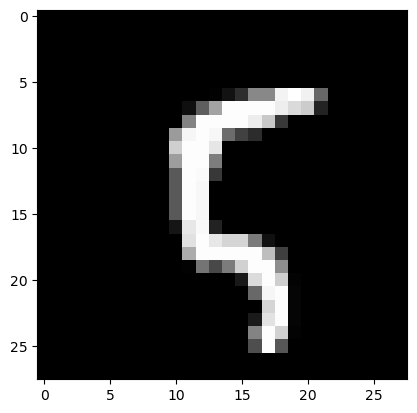

In [ ]:
image, label = test_dataset[100]
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
print('Label:', label)

In [ ]:
torch.max(model(image.cuda()).data, 1)

torch.return_types.max(
values=tensor([2.1405], device='cuda:0'),
indices=tensor([5], device='cuda:0'))